In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import random
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
import tensorflow as tf

In [2]:
def generator(data,size,snr,X,Y_,Phase):
    signal=np.zeros([size,8192])
    label=np.zeros([size,2])
    data=random.sample(data,size/2)
    data=np.array(data)
    for i in range(size):
        if i%2==0:
            r=random.randint(0,1638)
            label[i]=[0,1]
            signal[i,0:8191-r:1]=data[i/2,r:8191:1]*snr
            signal[i]+=np.random.normal(0,1,8192)
            signal[i]=signal[i]/np.std(signal[i])
        else:
            label[i]=[1,0]
            signal[i]=np.random.normal(0,1,8192)
    feed_dict={
        X:signal,
        Y_:label,
        phase:Phase
    }
    return feed_dict    

In [3]:
#get data
f=h5py.File('dataset.h5','r')
testsig=list(f['test'])
trainsig=list(f['train'])


In [4]:
sess=tf.Session()

#initial weight
def weight_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.contrib.layers.xavier_initializer())
#intial bias
def bias_variable(name,shape):
    return tf.get_variable(name,shape=shape,initializer=tf.constant_initializer(0.1))
#placeholder
with tf.name_scope('Input'):
    X=tf.placeholder(tf.float32,[None,8192])
with tf.name_scope('Label'):
    Y_=tf.placeholder(tf.float32,[None,2])
with tf.name_scope('Phase'):
    phase=tf.placeholder(tf.bool)

#reshape layer
with tf.name_scope('Reshape_layer'):
    XX=tf.reshape(X,[-1,8192,1,1])

#convolution layer 1
w_conv1=weight_variable('w_conv1',[16,1,1,16])
b_conv1=bias_variable('b_conv1',[16])
with tf.name_scope('Convolution_layer1'):
    conv1=tf.nn.conv2d(XX,w_conv1,strides=[1,1,1,1],padding='VALID')
print(conv1.shape)

#batch normalization layer 1
with tf.name_scope('BN_layer1'):
    conv1n=tf.contrib.layers.batch_norm(conv1,center=True, scale=True,is_training=phase)

#activation layer 1
with tf.name_scope('Relu_layer1'):
    h_conv1=tf.nn.relu(conv1n+b_conv1)

#pooling layer 1
with tf.name_scope('Pooling_layer1'):
    h_pool1=tf.nn.max_pool(h_conv1,[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool1.shape)

#convolution layer 2
w_conv2=weight_variable('w_conv2',[8,1,16,32])
b_conv2=bias_variable('b_conv2',[32])
with tf.name_scope('Convolution_layer2'):
    conv2=tf.nn.atrous_conv2d(h_pool1,w_conv2,rate=4,padding='VALID')
print(conv2.shape)

#batch normalization layer 2
with tf.name_scope('BN_layer2'):
    conv2n=tf.contrib.layers.batch_norm(conv2,center=True, scale=True,is_training=phase)

#activation layer 2
with tf.name_scope('Relu_layer2'):
    h_conv2=tf.nn.relu(conv2n+b_conv2)

#pooling layer 2
with tf.name_scope('Pooling_layer2'):
    h_pool2=tf.nn.max_pool(h_conv2,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool2)

#convolution layer 3
w_conv3=weight_variable('w_conv3',[8,1,32,64])
b_conv3=bias_variable('b_conv3',[64])
with tf.name_scope('Convolution_layer3'):
    conv3=tf.nn.atrous_conv2d(h_pool2,w_conv3,rate=4,padding='VALID')
print(conv3)

#batch normalization layer 3
with tf.name_scope('BN_layer3'):
    conv3n=tf.contrib.layers.batch_norm(conv3,center=True, scale=True,is_training=phase)

#activation layer 3
with tf.name_scope('Relu_layer3'):
    h_conv3=tf.nn.relu(conv3n+b_conv3)

#pooling layer 3
with tf.name_scope('Pooling_layer3'):
    h_pool3=tf.nn.max_pool(h_conv3,ksize=[1,4,1,1],strides=[1,4,1,1],padding='SAME')
print(h_pool3.shape)

#flatten layer
with tf.name_scope('Flatten_layer'):
    h_flatten=tf.reshape(h_pool3,[-1,7680])
print(h_flatten.shape)

#linear layer 1
w_linear1=weight_variable('w_linear1',[7680,64])
b_linear1=bias_variable('b_linear1',[64])

#batch normalization layer 4
with tf.name_scope('BN_layer4'):
    nh_flatten=tf.contrib.layers.batch_norm(h_flatten,center=True, scale=True,is_training=phase)

#activation layer 4
with tf.name_scope('Relu_layer4'):
    h_linear1=tf.nn.relu(tf.matmul(nh_flatten,w_linear1)+b_linear1)

#linear layer 2
w_linear2=weight_variable('w_linear2',[64,2])
b_linear2=bias_variable('b_linear2',[2])


#batch normalization layer 5
with tf.name_scope('BN_layer5'):
    h_linear1n=tf.contrib.layers.batch_norm(h_linear1,center=True, scale=True,is_training=phase)


#activation layer 5
Ylogits=tf.matmul(h_linear1n,w_linear2)+b_linear2
with tf.name_scope('Output'):
    Y=tf.nn.softmax(Ylogits)

#loss function
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits,labels=Y_)
cross_entropy=tf.reduce_mean(cross_entropy)

#accuracy
is_correct=tf.equal(tf.argmax(Y,1),tf.argmax(Y_,1))
accuracy=tf.reduce_mean(tf.cast(is_correct,tf.float32))*100

#optimization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
global_step = tf.Variable(0, name='global_step', trainable=False)
with tf.control_dependencies(update_ops):
    optimizer=tf.train.AdamOptimizer(0.001)
    train_step=optimizer.minimize(cross_entropy,global_step=global_step)

#save the model
saver=tf.train.Saver()

#visualization
tf.summary.scalar('accuracy',accuracy)
tf.summary.scalar('cross_entropy',tf.log(cross_entropy))
merged=tf.summary.merge_all()
train_writer=tf.summary.FileWriter('/home/txie/project/classifier/train/',sess.graph)
test_writer=tf.summary.FileWriter('/home/txie/project/classifier/test/')

#run
sess.run(tf.global_variables_initializer())

(?, 8177, 1, 16)
(?, 2045, 1, 16)
(?, ?, ?, 32)
Tensor("Pooling_layer2/MaxPool:0", shape=(?, ?, ?, 32), dtype=float32)
Tensor("Convolution_layer3/atrous_conv2d/BatchToSpaceND:0", shape=(?, ?, ?, 64), dtype=float32)
(?, ?, ?, 64)
(?, 7680)


In [5]:
#restore the model
ckpt = tf.train.get_checkpoint_state('/home/txie/project/classifier')  
saver.restore(sess,ckpt.model_checkpoint_path)
print('Model Restored')

Model Restored


In [6]:
#get test data
snr=0.25
test=generator(testsig,1480,snr,X,Y_,0)

In [7]:
#training loop
epoch=5000
for i in range(epoch):
    if (i+1)%100==0:
        summary,a,c=sess.run([merged,accuracy,cross_entropy],feed_dict=test)
        print('test:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
        test_writer.add_summary(summary,tf.train.global_step(sess,global_step))
    feed_dict=generator(trainsig,50,snr,X,Y_,1)
    a,c=sess.run([accuracy,cross_entropy],feed_dict=feed_dict)
    print('epoch:'+str(i)+' accuracy:'+str(a)+' cross_entropy:'+str(c))
    summary,_=sess.run([merged,train_step],feed_dict=feed_dict)
    train_writer.add_summary(summary,tf.train.global_step(sess,global_step))


epoch:0 accuracy:82.0 cross_entropy:0.405292
epoch:1 accuracy:90.0 cross_entropy:0.239418
epoch:2 accuracy:82.0 cross_entropy:0.372872
epoch:3 accuracy:88.0 cross_entropy:0.277644
epoch:4 accuracy:84.0 cross_entropy:0.355126
epoch:5 accuracy:78.0 cross_entropy:0.485603
epoch:6 accuracy:86.0 cross_entropy:0.331044
epoch:7 accuracy:84.0 cross_entropy:0.392341
epoch:8 accuracy:98.0 cross_entropy:0.269632
epoch:9 accuracy:86.0 cross_entropy:0.41501
epoch:10 accuracy:82.0 cross_entropy:0.421669
epoch:11 accuracy:86.0 cross_entropy:0.366267
epoch:12 accuracy:86.0 cross_entropy:0.294509
epoch:13 accuracy:80.0 cross_entropy:0.332557
epoch:14 accuracy:88.0 cross_entropy:0.342945
epoch:15 accuracy:86.0 cross_entropy:0.346075
epoch:16 accuracy:80.0 cross_entropy:0.438611
epoch:17 accuracy:78.0 cross_entropy:0.55486
epoch:18 accuracy:82.0 cross_entropy:0.392003
epoch:19 accuracy:92.0 cross_entropy:0.220663
epoch:20 accuracy:80.0 cross_entropy:0.393666
epoch:21 accuracy:82.0 cross_entropy:0.337449


epoch:176 accuracy:68.0 cross_entropy:0.492055
epoch:177 accuracy:84.0 cross_entropy:0.365575
epoch:178 accuracy:82.0 cross_entropy:0.38233
epoch:179 accuracy:84.0 cross_entropy:0.38309
epoch:180 accuracy:86.0 cross_entropy:0.292784
epoch:181 accuracy:90.0 cross_entropy:0.291946
epoch:182 accuracy:84.0 cross_entropy:0.383137
epoch:183 accuracy:84.0 cross_entropy:0.385025
epoch:184 accuracy:90.0 cross_entropy:0.334552
epoch:185 accuracy:88.0 cross_entropy:0.315754
epoch:186 accuracy:80.0 cross_entropy:0.497304
epoch:187 accuracy:88.0 cross_entropy:0.357294
epoch:188 accuracy:90.0 cross_entropy:0.25381
epoch:189 accuracy:88.0 cross_entropy:0.298316
epoch:190 accuracy:86.0 cross_entropy:0.394383
epoch:191 accuracy:90.0 cross_entropy:0.270537
epoch:192 accuracy:88.0 cross_entropy:0.313615
epoch:193 accuracy:90.0 cross_entropy:0.291153
epoch:194 accuracy:82.0 cross_entropy:0.345144
epoch:195 accuracy:84.0 cross_entropy:0.309313
epoch:196 accuracy:88.0 cross_entropy:0.356711
epoch:197 accura

epoch:350 accuracy:86.0 cross_entropy:0.28909
epoch:351 accuracy:88.0 cross_entropy:0.35921
epoch:352 accuracy:92.0 cross_entropy:0.260824
epoch:353 accuracy:92.0 cross_entropy:0.296773
epoch:354 accuracy:74.0 cross_entropy:0.426524
epoch:355 accuracy:92.0 cross_entropy:0.218529
epoch:356 accuracy:86.0 cross_entropy:0.361128
epoch:357 accuracy:80.0 cross_entropy:0.343047
epoch:358 accuracy:78.0 cross_entropy:0.42115
epoch:359 accuracy:86.0 cross_entropy:0.361893
epoch:360 accuracy:90.0 cross_entropy:0.271017
epoch:361 accuracy:78.0 cross_entropy:0.414266
epoch:362 accuracy:82.0 cross_entropy:0.310169
epoch:363 accuracy:76.0 cross_entropy:0.606127
epoch:364 accuracy:88.0 cross_entropy:0.311447
epoch:365 accuracy:86.0 cross_entropy:0.3534
epoch:366 accuracy:78.0 cross_entropy:0.507836
epoch:367 accuracy:78.0 cross_entropy:0.372034
epoch:368 accuracy:90.0 cross_entropy:0.292408
epoch:369 accuracy:84.0 cross_entropy:0.271977
epoch:370 accuracy:84.0 cross_entropy:0.293974
epoch:371 accuracy

epoch:525 accuracy:88.0 cross_entropy:0.34374
epoch:526 accuracy:88.0 cross_entropy:0.319333
epoch:527 accuracy:88.0 cross_entropy:0.306779
epoch:528 accuracy:86.0 cross_entropy:0.380084
epoch:529 accuracy:86.0 cross_entropy:0.292415
epoch:530 accuracy:80.0 cross_entropy:0.399933
epoch:531 accuracy:86.0 cross_entropy:0.377712
epoch:532 accuracy:86.0 cross_entropy:0.385537
epoch:533 accuracy:74.0 cross_entropy:0.446472
epoch:534 accuracy:84.0 cross_entropy:0.419996
epoch:535 accuracy:78.0 cross_entropy:0.438899
epoch:536 accuracy:82.0 cross_entropy:0.388251
epoch:537 accuracy:84.0 cross_entropy:0.389187
epoch:538 accuracy:78.0 cross_entropy:0.470879
epoch:539 accuracy:86.0 cross_entropy:0.309404
epoch:540 accuracy:72.0 cross_entropy:0.523009
epoch:541 accuracy:88.0 cross_entropy:0.283202
epoch:542 accuracy:80.0 cross_entropy:0.408294
epoch:543 accuracy:86.0 cross_entropy:0.378426
epoch:544 accuracy:80.0 cross_entropy:0.654013
epoch:545 accuracy:92.0 cross_entropy:0.293877
epoch:546 accu

test: accuracy:81.6892 cross_entropy:0.411759
epoch:699 accuracy:92.0 cross_entropy:0.229366
epoch:700 accuracy:88.0 cross_entropy:0.279981
epoch:701 accuracy:92.0 cross_entropy:0.245329
epoch:702 accuracy:84.0 cross_entropy:0.348941
epoch:703 accuracy:82.0 cross_entropy:0.336104
epoch:704 accuracy:84.0 cross_entropy:0.338231
epoch:705 accuracy:70.0 cross_entropy:0.556417
epoch:706 accuracy:90.0 cross_entropy:0.312918
epoch:707 accuracy:90.0 cross_entropy:0.296759
epoch:708 accuracy:92.0 cross_entropy:0.282876
epoch:709 accuracy:76.0 cross_entropy:0.461236
epoch:710 accuracy:72.0 cross_entropy:0.444877
epoch:711 accuracy:82.0 cross_entropy:0.383964
epoch:712 accuracy:78.0 cross_entropy:0.408723
epoch:713 accuracy:82.0 cross_entropy:0.474694
epoch:714 accuracy:88.0 cross_entropy:0.3372
epoch:715 accuracy:84.0 cross_entropy:0.357819
epoch:716 accuracy:86.0 cross_entropy:0.313632
epoch:717 accuracy:90.0 cross_entropy:0.224558
epoch:718 accuracy:88.0 cross_entropy:0.271082
epoch:719 accura

epoch:872 accuracy:88.0 cross_entropy:0.307319
epoch:873 accuracy:74.0 cross_entropy:0.458786
epoch:874 accuracy:86.0 cross_entropy:0.374672
epoch:875 accuracy:86.0 cross_entropy:0.291685
epoch:876 accuracy:88.0 cross_entropy:0.276615
epoch:877 accuracy:84.0 cross_entropy:0.36741
epoch:878 accuracy:78.0 cross_entropy:0.468758
epoch:879 accuracy:90.0 cross_entropy:0.299373
epoch:880 accuracy:88.0 cross_entropy:0.334896
epoch:881 accuracy:84.0 cross_entropy:0.301715
epoch:882 accuracy:84.0 cross_entropy:0.345192
epoch:883 accuracy:80.0 cross_entropy:0.383509
epoch:884 accuracy:88.0 cross_entropy:0.3223
epoch:885 accuracy:90.0 cross_entropy:0.243434
epoch:886 accuracy:82.0 cross_entropy:0.392181
epoch:887 accuracy:82.0 cross_entropy:0.362893
epoch:888 accuracy:86.0 cross_entropy:0.332755
epoch:889 accuracy:86.0 cross_entropy:0.308528
epoch:890 accuracy:84.0 cross_entropy:0.399017
epoch:891 accuracy:74.0 cross_entropy:0.556549
epoch:892 accuracy:82.0 cross_entropy:0.349379
epoch:893 accura

epoch:1046 accuracy:80.0 cross_entropy:0.382601
epoch:1047 accuracy:88.0 cross_entropy:0.310595
epoch:1048 accuracy:80.0 cross_entropy:0.385529
epoch:1049 accuracy:84.0 cross_entropy:0.30587
epoch:1050 accuracy:84.0 cross_entropy:0.320273
epoch:1051 accuracy:70.0 cross_entropy:0.538666
epoch:1052 accuracy:82.0 cross_entropy:0.453174
epoch:1053 accuracy:84.0 cross_entropy:0.313056
epoch:1054 accuracy:86.0 cross_entropy:0.341435
epoch:1055 accuracy:86.0 cross_entropy:0.279418
epoch:1056 accuracy:80.0 cross_entropy:0.40227
epoch:1057 accuracy:84.0 cross_entropy:0.364808
epoch:1058 accuracy:86.0 cross_entropy:0.373884
epoch:1059 accuracy:80.0 cross_entropy:0.452344
epoch:1060 accuracy:80.0 cross_entropy:0.473174
epoch:1061 accuracy:76.0 cross_entropy:0.417276
epoch:1062 accuracy:90.0 cross_entropy:0.260258
epoch:1063 accuracy:72.0 cross_entropy:0.470857
epoch:1064 accuracy:78.0 cross_entropy:0.432181
epoch:1065 accuracy:80.0 cross_entropy:0.423075
epoch:1066 accuracy:88.0 cross_entropy:0.3

epoch:1217 accuracy:84.0 cross_entropy:0.308747
epoch:1218 accuracy:88.0 cross_entropy:0.260622
epoch:1219 accuracy:88.0 cross_entropy:0.281471
epoch:1220 accuracy:82.0 cross_entropy:0.395629
epoch:1221 accuracy:84.0 cross_entropy:0.380801
epoch:1222 accuracy:82.0 cross_entropy:0.385561
epoch:1223 accuracy:86.0 cross_entropy:0.30742
epoch:1224 accuracy:88.0 cross_entropy:0.26117
epoch:1225 accuracy:82.0 cross_entropy:0.315822
epoch:1226 accuracy:94.0 cross_entropy:0.214742
epoch:1227 accuracy:80.0 cross_entropy:0.430404
epoch:1228 accuracy:84.0 cross_entropy:0.391388
epoch:1229 accuracy:88.0 cross_entropy:0.348766
epoch:1230 accuracy:72.0 cross_entropy:0.499966
epoch:1231 accuracy:84.0 cross_entropy:0.317683
epoch:1232 accuracy:88.0 cross_entropy:0.335813
epoch:1233 accuracy:86.0 cross_entropy:0.274688
epoch:1234 accuracy:88.0 cross_entropy:0.305036
epoch:1235 accuracy:76.0 cross_entropy:0.454832
epoch:1236 accuracy:88.0 cross_entropy:0.363042
epoch:1237 accuracy:86.0 cross_entropy:0.2

epoch:1388 accuracy:88.0 cross_entropy:0.307338
epoch:1389 accuracy:76.0 cross_entropy:0.513669
epoch:1390 accuracy:84.0 cross_entropy:0.403155
epoch:1391 accuracy:84.0 cross_entropy:0.384797
epoch:1392 accuracy:80.0 cross_entropy:0.411792
epoch:1393 accuracy:86.0 cross_entropy:0.348968
epoch:1394 accuracy:88.0 cross_entropy:0.268311
epoch:1395 accuracy:76.0 cross_entropy:0.456007
epoch:1396 accuracy:84.0 cross_entropy:0.3099
epoch:1397 accuracy:88.0 cross_entropy:0.350101
epoch:1398 accuracy:82.0 cross_entropy:0.404215
test: accuracy:81.0135 cross_entropy:0.40564
epoch:1399 accuracy:78.0 cross_entropy:0.504787
epoch:1400 accuracy:78.0 cross_entropy:0.486963
epoch:1401 accuracy:88.0 cross_entropy:0.327376
epoch:1402 accuracy:84.0 cross_entropy:0.358745
epoch:1403 accuracy:86.0 cross_entropy:0.434575
epoch:1404 accuracy:90.0 cross_entropy:0.273264
epoch:1405 accuracy:88.0 cross_entropy:0.309627
epoch:1406 accuracy:90.0 cross_entropy:0.277031
epoch:1407 accuracy:84.0 cross_entropy:0.3238

epoch:1559 accuracy:92.0 cross_entropy:0.254906
epoch:1560 accuracy:88.0 cross_entropy:0.347422
epoch:1561 accuracy:86.0 cross_entropy:0.306988
epoch:1562 accuracy:84.0 cross_entropy:0.33632
epoch:1563 accuracy:84.0 cross_entropy:0.495008
epoch:1564 accuracy:76.0 cross_entropy:0.462389
epoch:1565 accuracy:84.0 cross_entropy:0.445869
epoch:1566 accuracy:76.0 cross_entropy:0.367357
epoch:1567 accuracy:82.0 cross_entropy:0.477815
epoch:1568 accuracy:96.0 cross_entropy:0.228945
epoch:1569 accuracy:92.0 cross_entropy:0.221226
epoch:1570 accuracy:82.0 cross_entropy:0.413004
epoch:1571 accuracy:80.0 cross_entropy:0.438621
epoch:1572 accuracy:82.0 cross_entropy:0.412747
epoch:1573 accuracy:72.0 cross_entropy:0.526774
epoch:1574 accuracy:82.0 cross_entropy:0.363357
epoch:1575 accuracy:84.0 cross_entropy:0.386169
epoch:1576 accuracy:84.0 cross_entropy:0.348096
epoch:1577 accuracy:84.0 cross_entropy:0.395578
epoch:1578 accuracy:80.0 cross_entropy:0.440589
epoch:1579 accuracy:88.0 cross_entropy:0.

epoch:1730 accuracy:80.0 cross_entropy:0.38024
epoch:1731 accuracy:78.0 cross_entropy:0.436614
epoch:1732 accuracy:82.0 cross_entropy:0.361435
epoch:1733 accuracy:76.0 cross_entropy:0.461412
epoch:1734 accuracy:84.0 cross_entropy:0.37495
epoch:1735 accuracy:80.0 cross_entropy:0.397794
epoch:1736 accuracy:82.0 cross_entropy:0.34522
epoch:1737 accuracy:84.0 cross_entropy:0.348057
epoch:1738 accuracy:82.0 cross_entropy:0.383565
epoch:1739 accuracy:94.0 cross_entropy:0.240947
epoch:1740 accuracy:84.0 cross_entropy:0.37949
epoch:1741 accuracy:82.0 cross_entropy:0.421477
epoch:1742 accuracy:86.0 cross_entropy:0.383221
epoch:1743 accuracy:84.0 cross_entropy:0.391591
epoch:1744 accuracy:88.0 cross_entropy:0.317403
epoch:1745 accuracy:90.0 cross_entropy:0.227109
epoch:1746 accuracy:92.0 cross_entropy:0.237625
epoch:1747 accuracy:82.0 cross_entropy:0.395475
epoch:1748 accuracy:80.0 cross_entropy:0.377392
epoch:1749 accuracy:82.0 cross_entropy:0.408306
epoch:1750 accuracy:80.0 cross_entropy:0.346

epoch:1901 accuracy:80.0 cross_entropy:0.326348
epoch:1902 accuracy:84.0 cross_entropy:0.385963
epoch:1903 accuracy:90.0 cross_entropy:0.304397
epoch:1904 accuracy:82.0 cross_entropy:0.384508
epoch:1905 accuracy:90.0 cross_entropy:0.227162
epoch:1906 accuracy:84.0 cross_entropy:0.337342
epoch:1907 accuracy:84.0 cross_entropy:0.310246
epoch:1908 accuracy:88.0 cross_entropy:0.320719
epoch:1909 accuracy:80.0 cross_entropy:0.502136
epoch:1910 accuracy:78.0 cross_entropy:0.531211
epoch:1911 accuracy:84.0 cross_entropy:0.373833
epoch:1912 accuracy:84.0 cross_entropy:0.303012
epoch:1913 accuracy:80.0 cross_entropy:0.408637
epoch:1914 accuracy:80.0 cross_entropy:0.500881
epoch:1915 accuracy:84.0 cross_entropy:0.32405
epoch:1916 accuracy:84.0 cross_entropy:0.332519
epoch:1917 accuracy:84.0 cross_entropy:0.342814
epoch:1918 accuracy:82.0 cross_entropy:0.35421
epoch:1919 accuracy:88.0 cross_entropy:0.266988
epoch:1920 accuracy:86.0 cross_entropy:0.3462
epoch:1921 accuracy:84.0 cross_entropy:0.327

epoch:2072 accuracy:84.0 cross_entropy:0.40169
epoch:2073 accuracy:84.0 cross_entropy:0.357527
epoch:2074 accuracy:78.0 cross_entropy:0.427244
epoch:2075 accuracy:90.0 cross_entropy:0.276433
epoch:2076 accuracy:86.0 cross_entropy:0.344316
epoch:2077 accuracy:86.0 cross_entropy:0.317159
epoch:2078 accuracy:86.0 cross_entropy:0.363829
epoch:2079 accuracy:86.0 cross_entropy:0.328045
epoch:2080 accuracy:82.0 cross_entropy:0.439888
epoch:2081 accuracy:80.0 cross_entropy:0.386445
epoch:2082 accuracy:88.0 cross_entropy:0.352816
epoch:2083 accuracy:88.0 cross_entropy:0.268748
epoch:2084 accuracy:76.0 cross_entropy:0.490033
epoch:2085 accuracy:92.0 cross_entropy:0.249131
epoch:2086 accuracy:92.0 cross_entropy:0.228045
epoch:2087 accuracy:76.0 cross_entropy:0.51792
epoch:2088 accuracy:86.0 cross_entropy:0.332929
epoch:2089 accuracy:84.0 cross_entropy:0.300281
epoch:2090 accuracy:92.0 cross_entropy:0.207785
epoch:2091 accuracy:84.0 cross_entropy:0.400621
epoch:2092 accuracy:84.0 cross_entropy:0.3

epoch:2243 accuracy:84.0 cross_entropy:0.369641
epoch:2244 accuracy:86.0 cross_entropy:0.294045
epoch:2245 accuracy:88.0 cross_entropy:0.27278
epoch:2246 accuracy:90.0 cross_entropy:0.224874
epoch:2247 accuracy:86.0 cross_entropy:0.330235
epoch:2248 accuracy:90.0 cross_entropy:0.361909
epoch:2249 accuracy:86.0 cross_entropy:0.288032
epoch:2250 accuracy:82.0 cross_entropy:0.421638
epoch:2251 accuracy:88.0 cross_entropy:0.299771
epoch:2252 accuracy:80.0 cross_entropy:0.434941
epoch:2253 accuracy:94.0 cross_entropy:0.27962
epoch:2254 accuracy:84.0 cross_entropy:0.356229
epoch:2255 accuracy:76.0 cross_entropy:0.434518
epoch:2256 accuracy:82.0 cross_entropy:0.309454
epoch:2257 accuracy:84.0 cross_entropy:0.362036
epoch:2258 accuracy:82.0 cross_entropy:0.457156
epoch:2259 accuracy:78.0 cross_entropy:0.521978
epoch:2260 accuracy:94.0 cross_entropy:0.212533
epoch:2261 accuracy:78.0 cross_entropy:0.384031
epoch:2262 accuracy:86.0 cross_entropy:0.418903
epoch:2263 accuracy:90.0 cross_entropy:0.2

epoch:2414 accuracy:86.0 cross_entropy:0.371285
epoch:2415 accuracy:74.0 cross_entropy:0.490935
epoch:2416 accuracy:86.0 cross_entropy:0.33835
epoch:2417 accuracy:90.0 cross_entropy:0.326311
epoch:2418 accuracy:86.0 cross_entropy:0.306471
epoch:2419 accuracy:74.0 cross_entropy:0.57031
epoch:2420 accuracy:90.0 cross_entropy:0.219824
epoch:2421 accuracy:82.0 cross_entropy:0.355225
epoch:2422 accuracy:90.0 cross_entropy:0.329821
epoch:2423 accuracy:80.0 cross_entropy:0.463279
epoch:2424 accuracy:90.0 cross_entropy:0.391629
epoch:2425 accuracy:90.0 cross_entropy:0.274859
epoch:2426 accuracy:92.0 cross_entropy:0.261963
epoch:2427 accuracy:86.0 cross_entropy:0.377506
epoch:2428 accuracy:76.0 cross_entropy:0.47878
epoch:2429 accuracy:86.0 cross_entropy:0.374616
epoch:2430 accuracy:86.0 cross_entropy:0.340345
epoch:2431 accuracy:82.0 cross_entropy:0.425165
epoch:2432 accuracy:86.0 cross_entropy:0.376806
epoch:2433 accuracy:82.0 cross_entropy:0.418954
epoch:2434 accuracy:80.0 cross_entropy:0.37

epoch:2585 accuracy:68.0 cross_entropy:0.549505
epoch:2586 accuracy:90.0 cross_entropy:0.280495
epoch:2587 accuracy:86.0 cross_entropy:0.313496
epoch:2588 accuracy:88.0 cross_entropy:0.368846
epoch:2589 accuracy:84.0 cross_entropy:0.391128
epoch:2590 accuracy:82.0 cross_entropy:0.430115
epoch:2591 accuracy:90.0 cross_entropy:0.300025
epoch:2592 accuracy:76.0 cross_entropy:0.4633
epoch:2593 accuracy:78.0 cross_entropy:0.414866
epoch:2594 accuracy:92.0 cross_entropy:0.241391
epoch:2595 accuracy:90.0 cross_entropy:0.269294
epoch:2596 accuracy:86.0 cross_entropy:0.283203
epoch:2597 accuracy:92.0 cross_entropy:0.329897
epoch:2598 accuracy:86.0 cross_entropy:0.323593
test: accuracy:81.3514 cross_entropy:0.400032
epoch:2599 accuracy:84.0 cross_entropy:0.43384
epoch:2600 accuracy:86.0 cross_entropy:0.286341
epoch:2601 accuracy:84.0 cross_entropy:0.384523
epoch:2602 accuracy:88.0 cross_entropy:0.344581
epoch:2603 accuracy:88.0 cross_entropy:0.278502
epoch:2604 accuracy:86.0 cross_entropy:0.3923

epoch:2756 accuracy:84.0 cross_entropy:0.326174
epoch:2757 accuracy:92.0 cross_entropy:0.169898
epoch:2758 accuracy:90.0 cross_entropy:0.332674
epoch:2759 accuracy:86.0 cross_entropy:0.32816
epoch:2760 accuracy:86.0 cross_entropy:0.36593
epoch:2761 accuracy:92.0 cross_entropy:0.253316
epoch:2762 accuracy:86.0 cross_entropy:0.403678
epoch:2763 accuracy:80.0 cross_entropy:0.387079
epoch:2764 accuracy:78.0 cross_entropy:0.335208
epoch:2765 accuracy:74.0 cross_entropy:0.512626
epoch:2766 accuracy:82.0 cross_entropy:0.372662
epoch:2767 accuracy:84.0 cross_entropy:0.352153
epoch:2768 accuracy:80.0 cross_entropy:0.404277
epoch:2769 accuracy:90.0 cross_entropy:0.267715
epoch:2770 accuracy:82.0 cross_entropy:0.417476
epoch:2771 accuracy:82.0 cross_entropy:0.382204
epoch:2772 accuracy:80.0 cross_entropy:0.451903
epoch:2773 accuracy:86.0 cross_entropy:0.276822
epoch:2774 accuracy:84.0 cross_entropy:0.348631
epoch:2775 accuracy:82.0 cross_entropy:0.379316
epoch:2776 accuracy:82.0 cross_entropy:0.3

epoch:2926 accuracy:88.0 cross_entropy:0.299709
epoch:2927 accuracy:80.0 cross_entropy:0.434153
epoch:2928 accuracy:92.0 cross_entropy:0.289038
epoch:2929 accuracy:88.0 cross_entropy:0.277636
epoch:2930 accuracy:88.0 cross_entropy:0.345222
epoch:2931 accuracy:90.0 cross_entropy:0.247917
epoch:2932 accuracy:82.0 cross_entropy:0.411871
epoch:2933 accuracy:88.0 cross_entropy:0.359272
epoch:2934 accuracy:78.0 cross_entropy:0.334788
epoch:2935 accuracy:92.0 cross_entropy:0.252822
epoch:2936 accuracy:90.0 cross_entropy:0.344194
epoch:2937 accuracy:82.0 cross_entropy:0.368209
epoch:2938 accuracy:86.0 cross_entropy:0.296059
epoch:2939 accuracy:86.0 cross_entropy:0.28959
epoch:2940 accuracy:74.0 cross_entropy:0.521986
epoch:2941 accuracy:86.0 cross_entropy:0.278523
epoch:2942 accuracy:82.0 cross_entropy:0.435364
epoch:2943 accuracy:88.0 cross_entropy:0.286931
epoch:2944 accuracy:86.0 cross_entropy:0.260626
epoch:2945 accuracy:92.0 cross_entropy:0.29329
epoch:2946 accuracy:86.0 cross_entropy:0.3

test: accuracy:78.1081 cross_entropy:0.441039
epoch:3099 accuracy:84.0 cross_entropy:0.366083
epoch:3100 accuracy:74.0 cross_entropy:0.478414
epoch:3101 accuracy:82.0 cross_entropy:0.370266
epoch:3102 accuracy:82.0 cross_entropy:0.346105
epoch:3103 accuracy:86.0 cross_entropy:0.264876
epoch:3104 accuracy:82.0 cross_entropy:0.330283
epoch:3105 accuracy:88.0 cross_entropy:0.294641
epoch:3106 accuracy:82.0 cross_entropy:0.422359
epoch:3107 accuracy:84.0 cross_entropy:0.391435
epoch:3108 accuracy:76.0 cross_entropy:0.504633
epoch:3109 accuracy:76.0 cross_entropy:0.478995
epoch:3110 accuracy:82.0 cross_entropy:0.439124
epoch:3111 accuracy:90.0 cross_entropy:0.253481
epoch:3112 accuracy:94.0 cross_entropy:0.240745
epoch:3113 accuracy:82.0 cross_entropy:0.39465
epoch:3114 accuracy:82.0 cross_entropy:0.461073
epoch:3115 accuracy:90.0 cross_entropy:0.25685
epoch:3116 accuracy:82.0 cross_entropy:0.347685
epoch:3117 accuracy:92.0 cross_entropy:0.224752
epoch:3118 accuracy:84.0 cross_entropy:0.485

epoch:3269 accuracy:90.0 cross_entropy:0.29811
epoch:3270 accuracy:84.0 cross_entropy:0.383625
epoch:3271 accuracy:90.0 cross_entropy:0.237544
epoch:3272 accuracy:86.0 cross_entropy:0.295078
epoch:3273 accuracy:86.0 cross_entropy:0.309596
epoch:3274 accuracy:78.0 cross_entropy:0.384613
epoch:3275 accuracy:84.0 cross_entropy:0.347495
epoch:3276 accuracy:82.0 cross_entropy:0.348206
epoch:3277 accuracy:88.0 cross_entropy:0.270727
epoch:3278 accuracy:82.0 cross_entropy:0.338849
epoch:3279 accuracy:88.0 cross_entropy:0.324935
epoch:3280 accuracy:88.0 cross_entropy:0.255503
epoch:3281 accuracy:90.0 cross_entropy:0.271278
epoch:3282 accuracy:84.0 cross_entropy:0.370038
epoch:3283 accuracy:82.0 cross_entropy:0.390319
epoch:3284 accuracy:82.0 cross_entropy:0.379395
epoch:3285 accuracy:84.0 cross_entropy:0.360974
epoch:3286 accuracy:76.0 cross_entropy:0.466758
epoch:3287 accuracy:90.0 cross_entropy:0.299603
epoch:3288 accuracy:82.0 cross_entropy:0.440576
epoch:3289 accuracy:82.0 cross_entropy:0.

epoch:3441 accuracy:80.0 cross_entropy:0.368456
epoch:3442 accuracy:80.0 cross_entropy:0.37916
epoch:3443 accuracy:84.0 cross_entropy:0.433551
epoch:3444 accuracy:92.0 cross_entropy:0.244701
epoch:3445 accuracy:92.0 cross_entropy:0.225175
epoch:3446 accuracy:86.0 cross_entropy:0.257721
epoch:3447 accuracy:84.0 cross_entropy:0.392899
epoch:3448 accuracy:82.0 cross_entropy:0.409736
epoch:3449 accuracy:86.0 cross_entropy:0.340022
epoch:3450 accuracy:90.0 cross_entropy:0.25084
epoch:3451 accuracy:88.0 cross_entropy:0.308128
epoch:3452 accuracy:88.0 cross_entropy:0.297708
epoch:3453 accuracy:82.0 cross_entropy:0.393067
epoch:3454 accuracy:94.0 cross_entropy:0.307504
epoch:3455 accuracy:82.0 cross_entropy:0.476113
epoch:3456 accuracy:88.0 cross_entropy:0.242173
epoch:3457 accuracy:90.0 cross_entropy:0.356949
epoch:3458 accuracy:88.0 cross_entropy:0.309161
epoch:3459 accuracy:88.0 cross_entropy:0.302864
epoch:3460 accuracy:98.0 cross_entropy:0.175954
epoch:3461 accuracy:80.0 cross_entropy:0.4

epoch:3611 accuracy:94.0 cross_entropy:0.250165
epoch:3612 accuracy:76.0 cross_entropy:0.432246
epoch:3613 accuracy:78.0 cross_entropy:0.419991
epoch:3614 accuracy:80.0 cross_entropy:0.385655
epoch:3615 accuracy:76.0 cross_entropy:0.370111
epoch:3616 accuracy:84.0 cross_entropy:0.386896
epoch:3617 accuracy:82.0 cross_entropy:0.326086
epoch:3618 accuracy:86.0 cross_entropy:0.344535
epoch:3619 accuracy:92.0 cross_entropy:0.230681
epoch:3620 accuracy:80.0 cross_entropy:0.349199
epoch:3621 accuracy:80.0 cross_entropy:0.379728
epoch:3622 accuracy:84.0 cross_entropy:0.297257
epoch:3623 accuracy:84.0 cross_entropy:0.328718
epoch:3624 accuracy:96.0 cross_entropy:0.176458
epoch:3625 accuracy:88.0 cross_entropy:0.294771
epoch:3626 accuracy:82.0 cross_entropy:0.424166
epoch:3627 accuracy:84.0 cross_entropy:0.401297
epoch:3628 accuracy:88.0 cross_entropy:0.227383
epoch:3629 accuracy:80.0 cross_entropy:0.357665
epoch:3630 accuracy:78.0 cross_entropy:0.363146
epoch:3631 accuracy:82.0 cross_entropy:0

epoch:3783 accuracy:90.0 cross_entropy:0.213296
epoch:3784 accuracy:82.0 cross_entropy:0.413704
epoch:3785 accuracy:92.0 cross_entropy:0.220038
epoch:3786 accuracy:82.0 cross_entropy:0.408055
epoch:3787 accuracy:78.0 cross_entropy:0.51401
epoch:3788 accuracy:90.0 cross_entropy:0.296229
epoch:3789 accuracy:82.0 cross_entropy:0.388575
epoch:3790 accuracy:86.0 cross_entropy:0.292838
epoch:3791 accuracy:82.0 cross_entropy:0.364277
epoch:3792 accuracy:84.0 cross_entropy:0.319075
epoch:3793 accuracy:86.0 cross_entropy:0.302657
epoch:3794 accuracy:90.0 cross_entropy:0.261192
epoch:3795 accuracy:78.0 cross_entropy:0.451808
epoch:3796 accuracy:88.0 cross_entropy:0.365828
epoch:3797 accuracy:82.0 cross_entropy:0.469929
epoch:3798 accuracy:84.0 cross_entropy:0.372318
test: accuracy:77.5 cross_entropy:0.480935
epoch:3799 accuracy:80.0 cross_entropy:0.488451
epoch:3800 accuracy:78.0 cross_entropy:0.379136
epoch:3801 accuracy:76.0 cross_entropy:0.538839
epoch:3802 accuracy:76.0 cross_entropy:0.40428

epoch:3953 accuracy:90.0 cross_entropy:0.307465
epoch:3954 accuracy:78.0 cross_entropy:0.484977
epoch:3955 accuracy:84.0 cross_entropy:0.352399
epoch:3956 accuracy:82.0 cross_entropy:0.408688
epoch:3957 accuracy:90.0 cross_entropy:0.25326
epoch:3958 accuracy:84.0 cross_entropy:0.39398
epoch:3959 accuracy:90.0 cross_entropy:0.238108
epoch:3960 accuracy:78.0 cross_entropy:0.413702
epoch:3961 accuracy:84.0 cross_entropy:0.303389
epoch:3962 accuracy:76.0 cross_entropy:0.499294
epoch:3963 accuracy:90.0 cross_entropy:0.302374
epoch:3964 accuracy:78.0 cross_entropy:0.444008
epoch:3965 accuracy:80.0 cross_entropy:0.427076
epoch:3966 accuracy:86.0 cross_entropy:0.400069
epoch:3967 accuracy:78.0 cross_entropy:0.434257
epoch:3968 accuracy:84.0 cross_entropy:0.280997
epoch:3969 accuracy:82.0 cross_entropy:0.296796
epoch:3970 accuracy:82.0 cross_entropy:0.375737
epoch:3971 accuracy:82.0 cross_entropy:0.434509
epoch:3972 accuracy:82.0 cross_entropy:0.337906
epoch:3973 accuracy:84.0 cross_entropy:0.3

epoch:4124 accuracy:92.0 cross_entropy:0.29891
epoch:4125 accuracy:90.0 cross_entropy:0.211662
epoch:4126 accuracy:80.0 cross_entropy:0.510161
epoch:4127 accuracy:88.0 cross_entropy:0.316201
epoch:4128 accuracy:88.0 cross_entropy:0.354066
epoch:4129 accuracy:84.0 cross_entropy:0.321838
epoch:4130 accuracy:84.0 cross_entropy:0.305997
epoch:4131 accuracy:86.0 cross_entropy:0.263422
epoch:4132 accuracy:78.0 cross_entropy:0.464633
epoch:4133 accuracy:68.0 cross_entropy:0.507351
epoch:4134 accuracy:86.0 cross_entropy:0.367661
epoch:4135 accuracy:86.0 cross_entropy:0.305699
epoch:4136 accuracy:88.0 cross_entropy:0.293478
epoch:4137 accuracy:76.0 cross_entropy:0.46741
epoch:4138 accuracy:90.0 cross_entropy:0.300208
epoch:4139 accuracy:86.0 cross_entropy:0.324113
epoch:4140 accuracy:84.0 cross_entropy:0.365511
epoch:4141 accuracy:86.0 cross_entropy:0.311549
epoch:4142 accuracy:86.0 cross_entropy:0.406958
epoch:4143 accuracy:86.0 cross_entropy:0.33964
epoch:4144 accuracy:78.0 cross_entropy:0.42

epoch:4295 accuracy:86.0 cross_entropy:0.346217
epoch:4296 accuracy:84.0 cross_entropy:0.419082
epoch:4297 accuracy:76.0 cross_entropy:0.515897
epoch:4298 accuracy:88.0 cross_entropy:0.34105
test: accuracy:78.5811 cross_entropy:0.442467
epoch:4299 accuracy:80.0 cross_entropy:0.576309
epoch:4300 accuracy:92.0 cross_entropy:0.180082
epoch:4301 accuracy:74.0 cross_entropy:0.42463
epoch:4302 accuracy:84.0 cross_entropy:0.365113
epoch:4303 accuracy:84.0 cross_entropy:0.336867
epoch:4304 accuracy:80.0 cross_entropy:0.447283
epoch:4305 accuracy:82.0 cross_entropy:0.363624
epoch:4306 accuracy:90.0 cross_entropy:0.289166
epoch:4307 accuracy:82.0 cross_entropy:0.426519
epoch:4308 accuracy:86.0 cross_entropy:0.283692
epoch:4309 accuracy:90.0 cross_entropy:0.229385
epoch:4310 accuracy:86.0 cross_entropy:0.333154
epoch:4311 accuracy:80.0 cross_entropy:0.466495
epoch:4312 accuracy:90.0 cross_entropy:0.280284
epoch:4313 accuracy:78.0 cross_entropy:0.436529
epoch:4314 accuracy:82.0 cross_entropy:0.333

epoch:4466 accuracy:86.0 cross_entropy:0.404537
epoch:4467 accuracy:92.0 cross_entropy:0.275676
epoch:4468 accuracy:88.0 cross_entropy:0.28809
epoch:4469 accuracy:84.0 cross_entropy:0.417987
epoch:4470 accuracy:86.0 cross_entropy:0.285244
epoch:4471 accuracy:90.0 cross_entropy:0.296013
epoch:4472 accuracy:84.0 cross_entropy:0.322321
epoch:4473 accuracy:82.0 cross_entropy:0.296911
epoch:4474 accuracy:88.0 cross_entropy:0.34252
epoch:4475 accuracy:94.0 cross_entropy:0.248593
epoch:4476 accuracy:90.0 cross_entropy:0.312782
epoch:4477 accuracy:86.0 cross_entropy:0.348608
epoch:4478 accuracy:82.0 cross_entropy:0.374569
epoch:4479 accuracy:92.0 cross_entropy:0.284376
epoch:4480 accuracy:94.0 cross_entropy:0.252721
epoch:4481 accuracy:84.0 cross_entropy:0.342354
epoch:4482 accuracy:88.0 cross_entropy:0.342411
epoch:4483 accuracy:90.0 cross_entropy:0.355485
epoch:4484 accuracy:84.0 cross_entropy:0.407888
epoch:4485 accuracy:86.0 cross_entropy:0.356758
epoch:4486 accuracy:82.0 cross_entropy:0.3

epoch:4637 accuracy:88.0 cross_entropy:0.269772
epoch:4638 accuracy:84.0 cross_entropy:0.390755
epoch:4639 accuracy:78.0 cross_entropy:0.442096
epoch:4640 accuracy:88.0 cross_entropy:0.286462
epoch:4641 accuracy:74.0 cross_entropy:0.48353
epoch:4642 accuracy:88.0 cross_entropy:0.32435
epoch:4643 accuracy:88.0 cross_entropy:0.291359
epoch:4644 accuracy:90.0 cross_entropy:0.293419
epoch:4645 accuracy:80.0 cross_entropy:0.377161
epoch:4646 accuracy:84.0 cross_entropy:0.32447
epoch:4647 accuracy:82.0 cross_entropy:0.43829
epoch:4648 accuracy:86.0 cross_entropy:0.333329
epoch:4649 accuracy:88.0 cross_entropy:0.358365
epoch:4650 accuracy:74.0 cross_entropy:0.473157
epoch:4651 accuracy:90.0 cross_entropy:0.2426
epoch:4652 accuracy:82.0 cross_entropy:0.368411
epoch:4653 accuracy:84.0 cross_entropy:0.322434
epoch:4654 accuracy:74.0 cross_entropy:0.573314
epoch:4655 accuracy:80.0 cross_entropy:0.419312
epoch:4656 accuracy:76.0 cross_entropy:0.427691
epoch:4657 accuracy:76.0 cross_entropy:0.45218

epoch:4808 accuracy:76.0 cross_entropy:0.4129
epoch:4809 accuracy:90.0 cross_entropy:0.276955
epoch:4810 accuracy:82.0 cross_entropy:0.368343
epoch:4811 accuracy:80.0 cross_entropy:0.361705
epoch:4812 accuracy:86.0 cross_entropy:0.309346
epoch:4813 accuracy:82.0 cross_entropy:0.428416
epoch:4814 accuracy:88.0 cross_entropy:0.286397
epoch:4815 accuracy:84.0 cross_entropy:0.374997
epoch:4816 accuracy:88.0 cross_entropy:0.314552
epoch:4817 accuracy:80.0 cross_entropy:0.410636
epoch:4818 accuracy:88.0 cross_entropy:0.285381
epoch:4819 accuracy:84.0 cross_entropy:0.366284
epoch:4820 accuracy:80.0 cross_entropy:0.43234
epoch:4821 accuracy:80.0 cross_entropy:0.373149
epoch:4822 accuracy:82.0 cross_entropy:0.387938
epoch:4823 accuracy:88.0 cross_entropy:0.398287
epoch:4824 accuracy:84.0 cross_entropy:0.329193
epoch:4825 accuracy:84.0 cross_entropy:0.346292
epoch:4826 accuracy:82.0 cross_entropy:0.341893
epoch:4827 accuracy:94.0 cross_entropy:0.213114
epoch:4828 accuracy:86.0 cross_entropy:0.33

epoch:4980 accuracy:86.0 cross_entropy:0.275347
epoch:4981 accuracy:86.0 cross_entropy:0.351287
epoch:4982 accuracy:84.0 cross_entropy:0.335746
epoch:4983 accuracy:80.0 cross_entropy:0.396384
epoch:4984 accuracy:84.0 cross_entropy:0.403086
epoch:4985 accuracy:90.0 cross_entropy:0.277474
epoch:4986 accuracy:82.0 cross_entropy:0.408494
epoch:4987 accuracy:92.0 cross_entropy:0.239606
epoch:4988 accuracy:92.0 cross_entropy:0.228925
epoch:4989 accuracy:88.0 cross_entropy:0.281353
epoch:4990 accuracy:86.0 cross_entropy:0.32606
epoch:4991 accuracy:86.0 cross_entropy:0.36894
epoch:4992 accuracy:84.0 cross_entropy:0.368942
epoch:4993 accuracy:84.0 cross_entropy:0.31358
epoch:4994 accuracy:76.0 cross_entropy:0.379823
epoch:4995 accuracy:88.0 cross_entropy:0.315722
epoch:4996 accuracy:84.0 cross_entropy:0.45271
epoch:4997 accuracy:68.0 cross_entropy:0.599476
epoch:4998 accuracy:84.0 cross_entropy:0.299109
test: accuracy:81.2162 cross_entropy:0.388021
epoch:4999 accuracy:82.0 cross_entropy:0.30949

In [8]:
#save the model
saver.save(sess, '/home/txie/project/classifier/classifier.ckpt', global_step=epoch)
print('Model Saved')

Model Saved


0.2
test: accuracy:72.2297 cross_entropy:0.524381
0.3
test: accuracy:86.4865 cross_entropy:0.298028
0.4
test: accuracy:88.6486 cross_entropy:0.261354
0.5
test: accuracy:89.1892 cross_entropy:0.253183
0.6
test: accuracy:88.8514 cross_entropy:0.323197
0.7
test: accuracy:85.8108 cross_entropy:0.44409
0.8
test: accuracy:82.3649 cross_entropy:0.790195
0.9
test: accuracy:77.973 cross_entropy:1.29288
1.0
test: accuracy:74.1216 cross_entropy:2.08998
1.1
test: accuracy:67.3649 cross_entropy:3.48451
1.2
test: accuracy:63.4459 cross_entropy:5.15256
1.3
test: accuracy:60.0676 cross_entropy:6.67142
1.4
test: accuracy:57.8378 cross_entropy:8.62095
1.5
test: accuracy:55.0676 cross_entropy:11.1709
1.6
test: accuracy:53.3108 cross_entropy:12.8987
1.7
test: accuracy:51.1487 cross_entropy:15.2541
1.8
test: accuracy:49.1216 cross_entropy:17.2528
1.9
test: accuracy:48.2432 cross_entropy:18.8829
2.0
test: accuracy:47.6351 cross_entropy:20.9879
2.1
test: accuracy:45.8784 cross_entropy:23.0531
2.2
test: accur

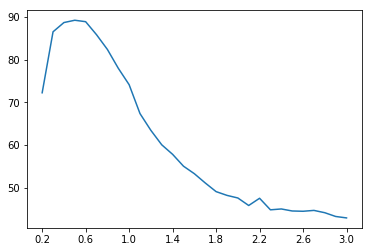

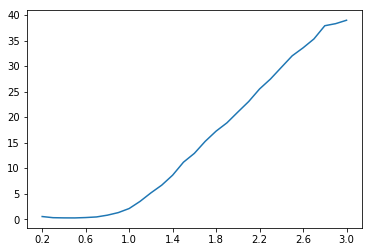

In [9]:
snr=np.linspace(0.2,3,29)
ac=[]
error=[]
for i in range(29):
    print(snr[i])
    test=generator(testsig,1480,snr[i],X,Y_,0)
    a,c=sess.run([accuracy,cross_entropy],feed_dict=test)
    print('test:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
    ac.append(a)
    error.append(c)
test=generator(testsig,1480,0.25,X,Y_,0)
a,c=sess.run([accuracy,cross_entropy],feed_dict=test)
print('snr=0.25:'+' accuracy:'+str(a)+' cross_entropy:'+str(c))
plt.figure()
plt.xticks(np.linspace(0.2,3,8))
plt.plot(snr,ac)
plt.figure()
plt.xticks(np.linspace(0.2,3,8))
plt.plot(snr,error)
plt.show()

    